# Psychophysics - Analyse des données

On va faire une regression logistique des données obtenues en psychophysiques, pour chercher le seuil B_theta vers lequel les gens perdent en performances. On le comparera ensuite qualitativement au performances du modèle pour essayer de valider sa plausibilité neurobiologique. 

In [1]:
%ls ./psychophysics_data/Psy_discrim_final*.p

 ./psychophysics_data/Psy_discrim_final_ACT.p
 ./psychophysics_data/Psy_discrim_final_AM.p
 ./psychophysics_data/Psy_discrim_final_BB.p
 ./psychophysics_data/Psy_discrim_final_DL.p
 ./psychophysics_data/Psy_discrim_final_FM.p
 ./psychophysics_data/Psy_discrim_final_HL.p
 ./psychophysics_data/Psy_discrim_final_KB.p
 ./psychophysics_data/Psy_discrim_final_LP.p
 ./psychophysics_data/Psy_discrim_final_MAP.p
 ./psychophysics_data/Psy_discrim_final_MB.p
'./psychophysics_data/Psy_discrim_final_Model - Perceptron.p'
'./psychophysics_data/Psy_discrim_final_Model - Ring.p'
 ./psychophysics_data/Psy_discrim_final_MP.p
 ./psychophysics_data/Psy_discrim_final_NP.p
 ./psychophysics_data/Psy_discrim_final_PA.p


En utilisant le modèle de régression logistique de scikit-learn, on fait un modèle pour chaque sujet :

# Tache de discrimination 

In [7]:
import pickle
import matplotlib.pyplot as plt

subj_name_list =  ['ACT', 'AM', 'BB', 'DL', 'FM', 'HL','KB', 'LP', 'MAP', 'MB', 'MP', 'NP', 'PA',
                  'Model - Ring', 'Model - Convo']
subj_data_list = []

for subject in subj_name_list :
#   x = pickle.load(open('Psychophys_discrim_2018-06-06_%s.p'%subject, 'rb'))
    x = pickle.load(open('./psychophysics_data/Psy_discrim_final_%s.p'%subject, 'rb'))
    subj_data_list.append(x)

En sujet individuel et en utilisant tout les B_theta:

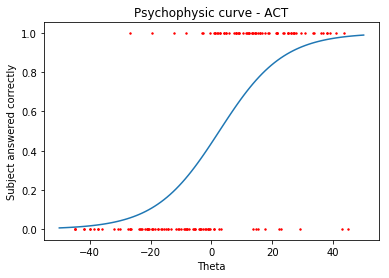

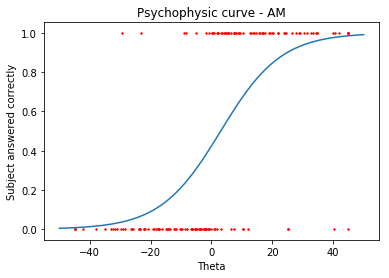

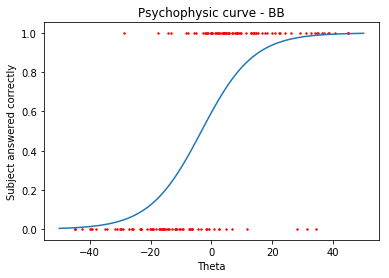

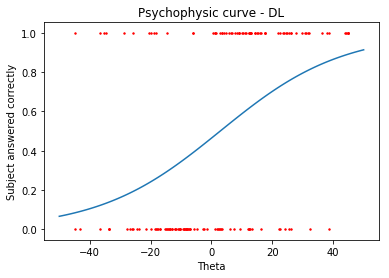

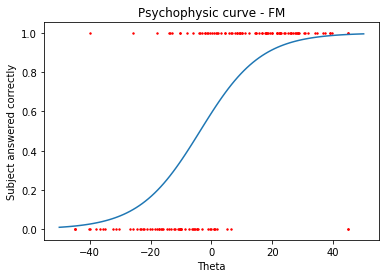

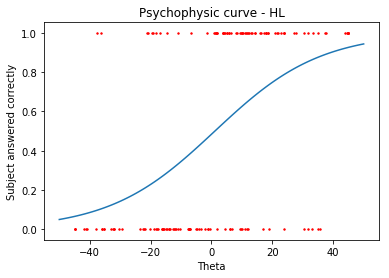

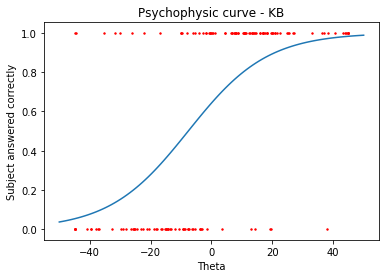

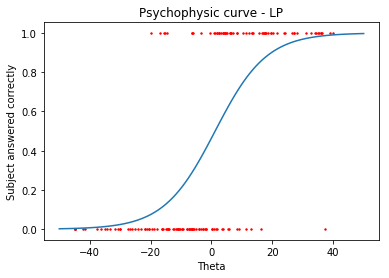

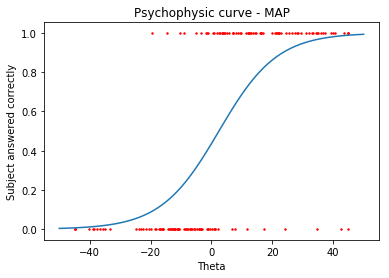

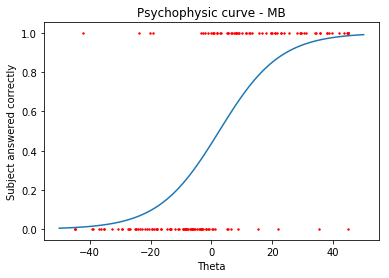

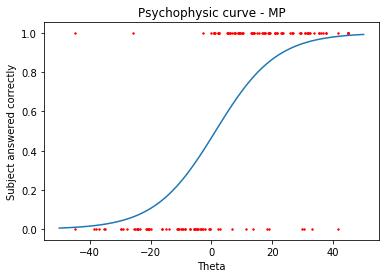

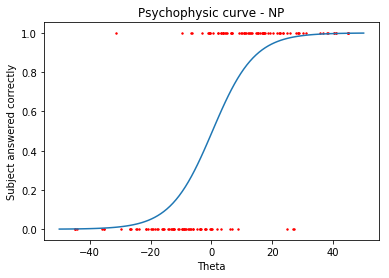

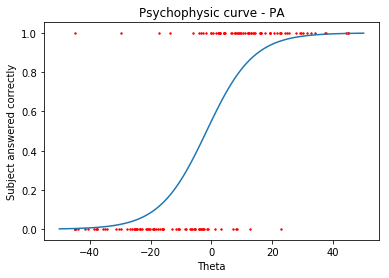

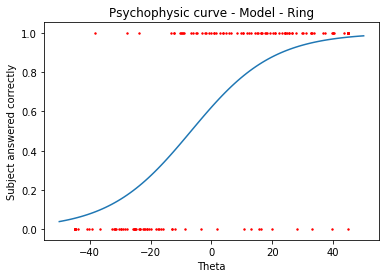

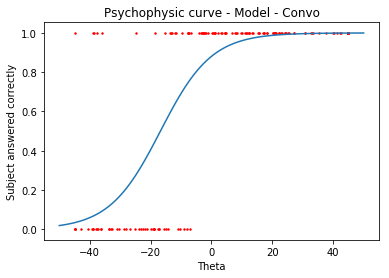

In [8]:
from sklearn.linear_model import LogisticRegression
import numpy as np

#the values used for plotting once the model is built
x_values = np.linspace(-50, 50, 100)
x_plot = np.reshape(x_values, (100,1))

for num, subj_data in enumerate(subj_data_list) :
    X = []
    for i in subj_data :
        #X.append(i[3]*180/np.pi)
        X.append(i[1]*180/np.pi)

    y =[]
    for i in subj_data :
        if False:
            # fitting if correct 
            if np.sign(i[1]) > 0 and i[2] == 'right':
                y.append(1)
            else :
                y.append(0)
            #y.append(i[1])
        else:
            # fitting with direction 
            if i[2] == 'right':
                y.append(1)
            else :
                y.append(0)
            #y.append(i[1])

    
    #reshaped for fitting
    X = np.asarray(X)
    X = X[:,np.newaxis]
    
    #logistic regression
    lgs = LogisticRegression(C = 3, max_iter = 100, penalty = 'l1' ,class_weight = {1 : 1 , 0 : 1}) 
    lgs.fit(X, y)
    #print(lgs.coef_)
    y_values = lgs.predict_proba(x_plot)[:,1]
    plt.plot(x_values, y_values, label = 'LogReg')

    plt.scatter(X, y, c='r', s=2)
    plt.title('Psychophysic curve - %s' % subj_name_list[num])
    plt.xlabel("Theta")
    plt.ylabel("Subject answered correctly")
    #plt.legend()
    plt.show()

En sujet individuel avec une courbe par B_theta :

In [9]:
b_thetas_list = []
for x in subj_data_list[0] :
    b_thetas_list.append(x[3]*180/np.pi)

b_thetas_list = sorted(set(b_thetas_list))
print(b_thetas_list)

[2.8125, 5.011305289539408, 8.929130917321123, 15.90990257669732, 28.34822362263465, 50.51079217392179, 90.0]


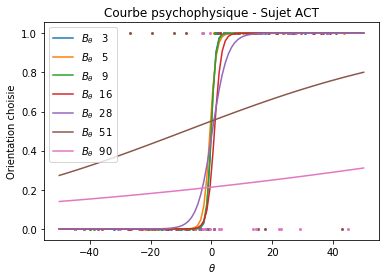

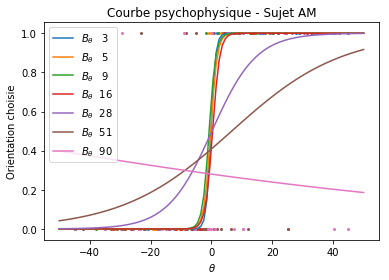

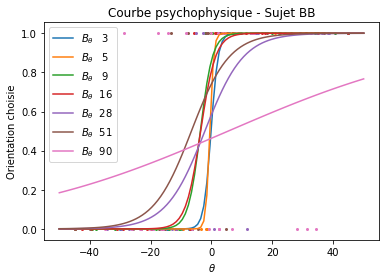

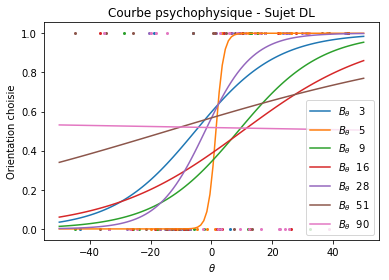

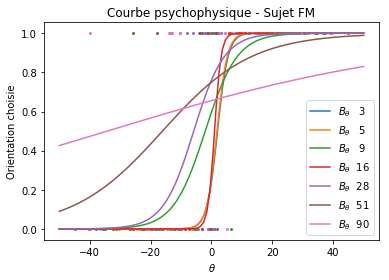

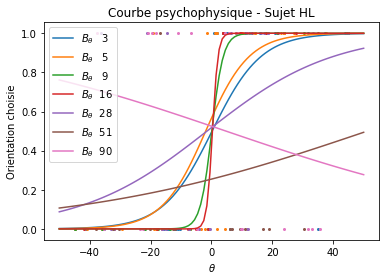

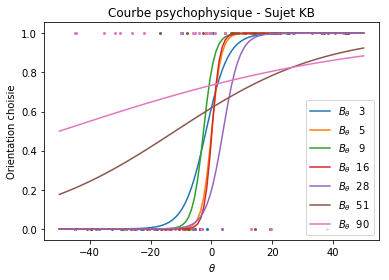

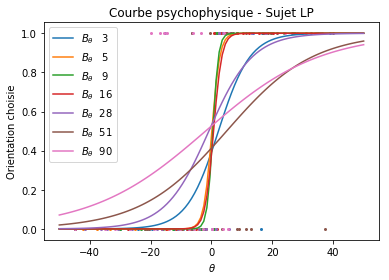

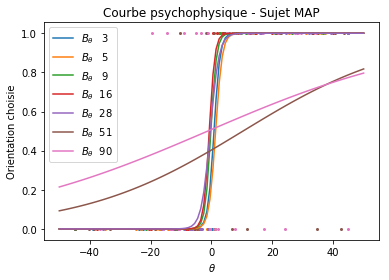

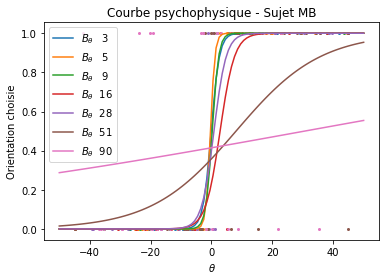

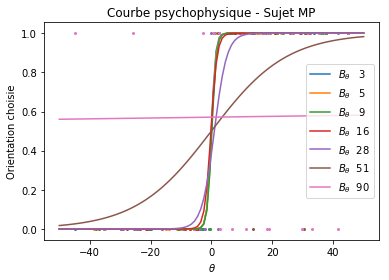

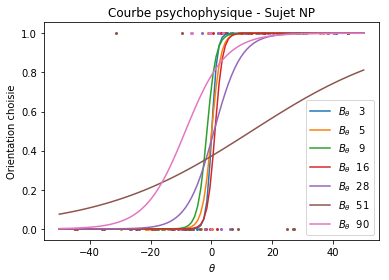

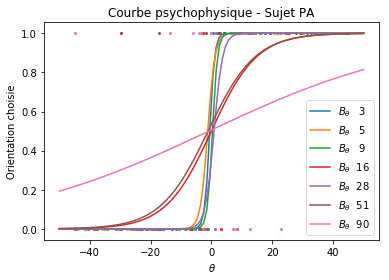

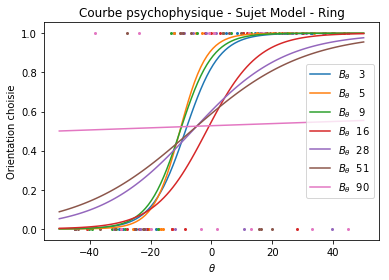

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

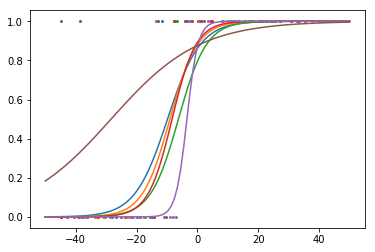

In [13]:
from sklearn.linear_model import LogisticRegression
import numpy as np

#the values used for plotting once the model is built
x_values = np.linspace(-50, 50, 100)
x_plot = np.reshape(x_values, (100,1))

lr_kwargs = dict(solver='liblinear', C = 3, max_iter=1000, penalty='l2', class_weight = {1 : 1 , 0 : 1})

coef_list = []

for num, subj_data in enumerate(subj_data_list) :
    for ibtheta, b_theta in enumerate(b_thetas_list):
        X = []
        y =[]

        for i in subj_data :
            if i[3]*180/np.pi == b_theta :
                X.append(i[1]*180/np.pi)
                if False:
                    # fitting if correct 
                    if np.sign(i[1]) > 0 and i[2] == 'right':
                        y.append(1)
                    else :
                        y.append(0)
                    #y.append(i[1])
                else:
                    # fitting with direction 
                    if i[2] == 'right':
                        y.append(1)
                    else :
                        y.append(0)
                    #y.append(i[1])


        #reshaped for fitting
        X = np.asarray(X)
        X = X[:,np.newaxis]

        #logistic regression
        lgs = LogisticRegression(**lr_kwargs) 
        lgs.fit(X, y)
        
        coef_list.append((b_theta,lgs.coef_[0][0]))
        
        y_values = lgs.predict_proba(x_plot)[:,1]
        plt.plot(x_values, y_values, label = r'$B_\theta$ %3.f' %b_theta)
        plt.scatter(X, y, s=4)
    plt.title('Courbe psychophysique - Sujet %s' % subj_name_list[num])
    plt.xlabel(r'$\theta$')
    plt.ylabel("Orientation choisie")
    plt.savefig('./figs/Psychodiscri_curve_subj_%s.pdf' % subj_name_list[num],format='pdf', dpi=1000)
    plt.legend()
    plt.show()

# F1 Score

In [27]:
import sklearn.metrics as metrics
import pickle
import matplotlib.pyplot as plt

#pas beau en subject average, il doit y avoir des outliers a eliminer
#subj_name_list =  ['ACT', 'AM', 'BB', 'DL', 'FM', 'HL','KB', 'LP', 'MAP', 'MB', 'MP', 'NP', 'PA']


def f1_score(subj_name_list):
    subj_data_list = []
    for subject in subj_name_list :
    #   x = pickle.load(open('Psychophys_discrim_2018-06-06_%s.p'%subject, 'rb'))
        x = pickle.load(open('./psychophysics_data/Psy_discrim_final_%s.p'%subject, 'rb'))
        subj_data_list.append(x)

    f1_list = []
    #Reminder, trials are in the form of [numtrial, shift angle, answered direction, b_theta]

    #for each b_theta, we loop through all the trials of each subject and we append trials whose b_theta
    #is the one we are currently selecting. We then compute f1 score and append it to a f1 list
    for b_theta in b_thetas_list :
        dir_list = []
        answered_list  = []
        for subj in subj_data_list :
            for trials in subj :
                if trials[3]*180/np.pi == b_theta :
                    if trials[2] == 'left' :
                        dir_list.append(0)
                    if trials[2] == 'right':
                        dir_list.append(1)

                    if np.sign(trials[1]) < 0 :
                        answered_list.append(0)
                    if np.sign(trials[1]) > 0 :
                        answered_list.append(1)
        f1_list.append(metrics.f1_score(dir_list, answered_list))
        
    return f1_list
        
hum_f1 = f1_score(['AM'])
convo_f1 = f1_score(['Model - Convo'])
rnn_f1 = f1_score(['Model - Ring'])

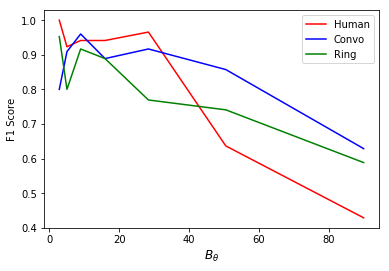

In [45]:
#plt.plot(b_thetas_list, f1_list)
plt.figure(figsize = (6,4))
plt.plot(b_thetas_list, hum_f1, color = 'red', label = 'Human')
plt.plot(b_thetas_list, convo_f1, color = 'blue', label = 'Convo')
plt.plot(b_thetas_list, rnn_f1, color = 'green', label = 'Ring')
plt.xlabel(r'$B_\theta$', fontsize = 12)
plt.ylabel('F1 Score', fontsize = 10)
plt.legend()
#plt.title(r'Variation du F1 score en fonction de $B_\theta$')
plt.savefig('./figs/F1_curve.eps',format='eps', dpi=1000)
plt.show()

# Coefficient de regression

In [ ]:
avg_list = []
plt_list = []
for b_theta in b_thetas_list :
    avg_list = []
    for coef in coef_list :
        if coef[0] == b_theta :
            avg_list.append(coef[1])
    plt_list.append(np.mean(avg_list))

plt.plot(b_thetas_list, plt_list)
plt.xlabel(r'$B_\theta$')
plt.ylabel('Coefficient moyen de regression')
plt.title(r'Variation du coefficient de regression en fonction de $B_\theta$')
plt.savefig('./figs/B_theta_curve.eps',format='eps', dpi=1000)
plt.show()